In [47]:
import pandas as pd
import numpy as np
import bs4
from bs4 import BeautifulSoup
from time import sleep
from selenium import webdriver
from selenium.common.exceptions import TimeoutException
from selenium.webdriver.common.keys import Keys
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.chrome.service import Service
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from urllib import request
import datetime
import requests

from PIL import Image
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
import matplotlib.pyplot as plt
import seaborn as sns

# # Setting browser

# Setting browser's options
options = webdriver.ChromeOptions()
options.add_argument('--ignore-certificate-errors')
options.add_argument("--start-maximized")
options.add_argument("--disable-popup-blocking")

#path to the installed compatible chromedriver
path = 'C:\webdrivers\chromedriver.exe'
driver = webdriver.Chrome(executable_path = path)

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:33: DeprecationWarning: executable_path has been deprecated, please pass in a Service object


In [3]:

# Access to Glints website
driver.get('https://glints.com/vn/opportunities/jobs/explore')
print('-- Glints accessed')

sleep(2)
#
res = requests.get(driver.current_url)
soup2 = BeautifulSoup(res.text, 'html.parser')
page_source = BeautifulSoup(driver.page_source)



#Close pop-up. Pop-up will appear only if the page was scrolled down (took a long time to figure out tho)
#pop_up = WebDriverWait(driver,10).until(EC.presence_of_element_located((By.XPATH, '//*[@id="__next"]/div/div[3]/div[2]/div[2]/div[2]/div[5]/div/div/div/header/button')))
html = driver.find_element(By.TAG_NAME, 'html')
html.send_keys(Keys.DOWN)
sleep(1)
html.send_keys(Keys.ESCAPE)
html.send_keys(Keys.UP)
driver.implicitly_wait(1)

#Send job search keyword:
#key_word = input('Input keyword: ') 
keyword = 'Data Analyst'
job_input = driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[3]/div[2]/div[2]/div[2]/div[2]/div/div/div[1]/div/input')
sleep(1)
job_input.send_keys(Keys.CONTROL + "a")
job_input.send_keys(Keys.DELETE)
job_input.send_keys(keyword)
job_input.send_keys(Keys.RETURN)

#Click search
search_button = driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[3]/div[2]/div[2]/div[2]/div[2]/div/div/div[3]/button')
search_button.send_keys(Keys.ENTER)
print('-- Start searching...')

#Infinite scroll so instead of define Next button
#But scroll fairly to the bottom and wait until the very last page loaded
while True:
    page_height = driver.execute_script("return document.body.scrollHeight")
    target_height = page_height - 1220
    driver.execute_script("window.scrollTo(0, %s);" %target_height )
    sleep(2)
    try:
        state = driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[3]/div[2]/div[2]/div[2]/div[4]/div[2]/div[2]/span')
        if state.text == 'Đã tải lên tất cả cơ hội việc làm': 
            print('-- All page loaded') 
            break
    except:
        continue 
        
job_id = BeautifulSoup(driver.page_source).find_all('a', class_='CompactOpportunityCardsc__CardAnchorWrapper-sc-1y4v110-18 iOjUdU job-search-results_job-card_link')
print("-- Found {} jobs.".format(len(job_id)))
print("-- Start crawling job's detailed information")


#Get link for each job
job_url = []
for i in job_id:
    link = i.get('href')
    url = 'https://glints.com'+link
    job_url.append(url)


C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:11: DeprecationWarning: executable_path has been deprecated, please pass in a Service object
  # This is added back by InteractiveShellApp.init_path()


-- Glints accessed
-- Start searching...
-- All page loaded
-- Found 1970 jobs.
-- Start crawling job's detailed information


In [22]:
#Export job_url list to file in order to prevent data loss due to sudden termination of the program
with open('Glints_joburl_221110.txt', 'w') as f:
    for line in job_url:
        f.write("%s\n" % line)

In [42]:
###Import job_url to list. If one restart the notebook and just wanna jump right into the crawling process.

# with open('Glints_joburl_221110.txt', 'r') as f:
#     job_url = f.read().split("\n")[:-1]


In [63]:
# #Define the DataFrame structure
# df = pd.DataFrame(columns = ["job_title", 'job_link', "company_name", "company_link", "salary", "currency",
#                            "category", "contract", "experience", "benefit", "requirement",'industry',
#                            "company_size", "company_location", "job_location", "posted", "updated"])

#Define a dict which will be appended to the df after each link being crawled
crawl_set = {}



for link in job_url[len(df):]:
    driver.get(link)
#     sleep(3)
    try:
        element = WebDriverWait(driver, 20).until(EC.presence_of_element_located((By.CSS_SELECTOR, 'div[class="GlintsContainer-sc-ap1z3q-0 iUnyrV"]')))
        html_of_interest = driver.execute_script('return arguments[0].innerHTML',element)
        soup = BeautifulSoup(html_of_interest, 'lxml')
    except:
        print('Error orcurred at url: {}'.format(link))
        continue
        
    #Job title
    try:
        crawl_set['job_title'] = soup.select('div[class="TopFoldsc__JobOverviewHeader-sc-kklg8i-24 gfOGEj"]')[0].text
    except:
        crawl_set['job_title'] = None
        
    #Company name
    try:
        crawl_set['company_name'] = soup.select('div[class ="TopFoldsc__JobOverViewCompanyName-sc-kklg8i-5 eLQvRY"]>a')[0].text
    except:
        crawl_set['company_name'] = None
        
    #Company profile
    try:
        crawl_set['company_link'] = driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[3]/div[2]/div[2]/div[2]/div/main/div[1]/div[2]/div/div[2]/div/a').get_attribute('href')
    except:
        crawl_set['company_link'] = None
        
    #salary
    try:
        crawl_set['salary'] = soup.select('span[class="TopFoldsc__BasicSalary-sc-kklg8i-15 lolAnb"]')[0].text
        ##soup.select('.TopFoldsc__JobOverViewInfo-sc-kklg8i-9.EWOdY')[0].text
    except:
        crawl_set['salary'] = None
        
    #currency 
    try:
        crawl_set['currency'] = soup.select('span[class="TopFoldsc__CurrencyCode-sc-kklg8i-30 eCrNiw"]')[0].text
    except:
        crawl_set['currency'] = None
        
    #category
    try:
        crawl_set['category'] = soup.select('div[class="TopFoldsc__JobOverViewInfo-sc-kklg8i-9 EWOdY"]>a')[0].text
        ##soup.select('.TopFoldsc__JobOverViewInfo-sc-kklg8i-9.EWOdY')[1].text
    except:
        crawl_set['category'] = None
        
    #contract
    try:
        crawl_set['contract'] = soup.select('div[class="TopFoldsc__JobOverViewInfo-sc-kklg8i-9 EWOdY"]')[1].text
        ##soup.select('.TopFoldsc__JobOverViewInfo-sc-kklg8i-9.EWOdY')[2].text
    except:
        crawl_set['contract'] = None

    #experience
    try:
        crawl_set['experience'] = soup.select('div[class="TopFoldsc__JobOverViewInfo-sc-kklg8i-9 EWOdY"]')[2].text
        ##soup.select('.TopFoldsc__JobOverViewInfo-sc-kklg8i-9.EWOdY')[3].text
    except:
        crawl_set['experience'] = None

    #requirement
    requirement = soup.select('.TagStyle__TagContent-sc-66xi2f-0.bxpfKm.tag-content')
    req_list = []
    for i in range(len(requirement)):
        req_list.append(requirement[i].text)
    crawl_set['requirement'] = ','.join(req_list)

    #benefit packages
    try:
        benefit = soup.select('ul[class="Benefitssc__BenefitList-sc-10xec8z-1 iCclQu"]>li>div>h3')
        benefit_list = []
        if len(benefit_list)!=0:
            for i in benefit:
                benefit_list.append(i.text)
            crawl_set['benefit'] = ','.join(benefit_list)
        else:
            crawl_set['benefit'] = None
    except:
        crawl_set['benefit'] = None


    #industry
    try:
        crawl_set['industry'] = soup.select('div[class="AboutCompanySectionsc__CompanyIndustryAndSize-sc-7g2mk6-7 iGZjWK"]>span')[0].text
    except:
        crawl_set['industry'] = None



    #Company size
    try:
        crawl_set['company_size'] = soup.select('div[class="AboutCompanySectionsc__CompanyIndustryAndSize-sc-7g2mk6-7 iGZjWK"]>span')[1].text
    except:
        crawl_set['company_size'] = None


    #company_location
    try:
        crawl_set['company_location'] = soup.select('div[class="AboutCompanySectionsc__AddressWrapper-sc-7g2mk6-14 bBEGUc"]')[0].text
    except:
        crawl_set['company_location'] = None

    #job location
    try:
        crawl_set['job_location'] = driver.find_element(By.XPATH, '//*[@id="__next"]/div/div[3]/div[2]/div[2]/div[1]/div/label[3]/a').text.lstrip('Việc Làm Tại')
    except:
        crawl_set['job_location'] = None

    #post
    try:
        posted = soup.select('span[class="TopFoldsc__PostedAt-sc-kklg8i-13 vnaHT"]')
        posted = posted[0].text.split(' ',1)[1]
        crawl_set['posted'] = posted
    except:
        crawl_set['posted'] = None
    #update
    try:
        updated = soup.select('span[class="TopFoldsc__UpdatedAt-sc-kklg8i-14 kjxTBC"]')
        updated = updated[0].text.split(' ',1)[1]
        crawl_set['updated'] = updated
    except:
        crawl_set['updated'] = None
        
    #job_link
    try:
        crawl_set['job_link'] = link
    except:
        crawl_set['job_link'] = 'Error'

    #crawled time
    crawl_set['scrapped_time'] = datetime.datetime.now().strftime('%Y-%m-%d %H:%M:%S')

    df=df.append(crawl_set, ignore_index = True)
    
    if len(df) == len(job_url):
        print('--Finish scrapping')
    elif len(df)%20 == 0:
        print('--There are {} links scraped as {}% of total. {} to go. Continue...'.format(len(df), round(len(df)/len(job_url)*100,2), len(job_url)-len(df)))


    

Error orcurred at url: https://glints.com/vn/opportunities/jobs/business-analyst-ke-toan-tai-chinh-logistic/64431579-2a13-42ae-898e-4d571df84698
--There are 220 links scraped as 0.11% of total. 1750 to go. Continue...
--There are 240 links scraped as 0.12% of total. 1730 to go. Continue...
--There are 260 links scraped as 0.13% of total. 1710 to go. Continue...
--There are 280 links scraped as 0.14% of total. 1690 to go. Continue...
--There are 300 links scraped as 0.15% of total. 1670 to go. Continue...
--There are 320 links scraped as 0.16% of total. 1650 to go. Continue...
--There are 340 links scraped as 0.17% of total. 1630 to go. Continue...
--There are 360 links scraped as 0.18% of total. 1610 to go. Continue...
--There are 380 links scraped as 0.19% of total. 1590 to go. Continue...
--There are 400 links scraped as 0.2% of total. 1570 to go. Continue...
--There are 420 links scraped as 0.21% of total. 1550 to go. Continue...
--There are 440 links scraped as 0.22% of total. 1530

In [68]:
df.to_csv('Glintsdata_221111.csv')

In [69]:
#check duplicate
df.drop_duplicates(subset = df.columns[:-1])

,job_title,job_link,company_name,company_link,salary,currency,category,contract,experience,benefit,requirement,industry,company_size,company_location,job_location,posted,updated,scrapped_time
0,[Glints 5 Ngày] Data Engineer,https://glints.com/vn/opportunities/jobs/glint...,"Bbv Vietnam Co., Ltd",https://glints.com/vn/companies/bbv-vietnam-co...,VND40.000.000/month,VND,Software Engineering,Việc làm fulltime,3 - 5 năm kinh nghiệm,None,"Interpersonal Skills,English,Analyzing skills,...",,None,None,Ho Chi Minh City,7 ngày trước,nhật 4 ngày trước,2022-11-11 13:42:04
1,[Glints 5 Ngày] Head Of Product,https://glints.com/vn/opportunities/jobs/glint...,Be Group,https://glints.com/vn/companies/be-group/6a190...,USD7.000 - 10.000/month,USD,Product Management,Việc làm fulltime,5 - 10 năm kinh nghiệm,None,"English,Strong Leadership Skills,Product Devel...",,201-500 nhân viên,"Địa chỉ văn phòngTầng 16, Tòa Nhà Sai Gon Towe...",Ho Chi Minh City,7 ngày trước,nhật 4 ngày trước,2022-11-11 13:42:09
2,[Glints 5 Ngày] Backend Developer,https://glints.com/vn/opportunities/jobs/glint...,Poc Pharma,https://glints.com/vn/companies/poc-pharma/d54...,USD1.000 - 4.000/month,USD,Software Engineering,Việc làm fulltime,3 - 5 năm kinh nghiệm,None,"Backend Developer,Data Structures,Critical Thi...",Pharmaceuticals,51-200 nhân viên,"Địa chỉ văn phòng 50 Tôn Thất Đạm, Phường Nguy...",Ho Chi Minh City,7 ngày trước,nhật 4 ngày trước,2022-11-11 13:42:17
3,[Glints 5 Ngày] Senior/Lead Backend Engineer,https://glints.com/vn/opportunities/jobs/glint...,Elfie,https://glints.com/vn/companies/elfie/f3c32e5b...,USD3.500 - 5.500/month,USD,Software Engineering,Việc làm fulltime,5 - 10 năm kinh nghiệm,None,"Nosql,Data Modeling,Cloud Infrastructure,nodej...",,11-50 nhân viên,"Địa chỉ văn phòngTầng 2, 124 Điện Biên Phủ, Ph...",Ho Chi Minh City,7 ngày trước,nhật 4 ngày trước,2022-11-11 13:42:21
4,[Glints 5 Ngày] Head of Sales,https://glints.com/vn/opportunities/jobs/glint...,John Hu Migration Consulting Viet Nam,https://glints.com/vn/companies/john-hu-migrat...,USD4.000/month,USD,Business Development / Sales,Việc làm fulltime,Hơn 10 năm kinh nghiệm,None,"English,Financial Literacy,Stakeholder Managem...",,11-50 nhân viên,None,Ho Chi Minh City,8 ngày trước,nhật 4 ngày trước,2022-11-11 13:42:25
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1964,Java developer (EDI tech),https://glints.com/vn/opportunities/jobs/java-...,Ekino Vietnam,https://glints.com/vn/companies/ekino-vietnam/...,IDR100 - 200/month,IDR,Software Engineering,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"English,Java,Design Database,SQL",Information Technology and Services,51-200 nhân viên,None,Ho Chi Minh City,1 tháng trước,nhật 1 tháng trước,2022-11-11 16:47:56
1965,Content Manager,https://glints.com/vn/opportunities/jobs/conte...,Anneco Agency,https://glints.com/vn/companies/anneco-agency/...,None,None,Other,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"Creative,Management,Content Marketing",,11-50 nhân viên,"Địa chỉ văn phòng85-86-87 Bến Vân Đồn, Phường ...",Ho Chi Minh City,5 tháng trước,nhật 26 ngày trước,2022-11-11 16:48:04
1966,Mobile Developer,https://glints.com/vn/opportunities/jobs/mobil...,Innomizetech,https://glints.com/vn/companies/innomizetech/1...,USD1.000 - 2.500/month,USD,Software Engineering,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"JavaScript,React Native,Flutter,Typescript",Outsourcing/Offshoring,11-50 nhân viên,None,Ho Chi Minh City,2 tháng trước,nhật 8 ngày trước,2022-11-11 16:48:11
1967,UI/UX Designer (Product Design),https://glints.com/vn/opportunities/jobs/ui-ux...,Advesa Digital Solutions,https://glints.com/vn/companies/advesa-digital...,USD1.700/month,USD,Design,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"Ux Research,Design Thinking,UIUX Design",Marketing and Advertising,201-500 nhân viên,None,Hà Nội,4 tháng trước,nhật 2 ngày trước,2022-11-11 16:48:28


### ____________________ _FINISH SCRAPING_ ____________________

#### Wrangling Data

In [164]:
###Salary
#Period-based

df['salary_period'] = df.salary.str.split( '/').str[1]

#Get salary as number with upper bound and lower bound
df.salary.str.split('/').str[0].str[3:]

C:\ProgramData\Anaconda3\lib\site-packages\ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [192]:
df.salary.str.split('/').str[0].str[3:]

0                    40.000.000
1                    12.000.000
2                7.000 - 10.000
3                 1.000 - 4.000
4                 3.500 - 5.500
                 ...           
1947              1.000 - 2.500
1948    30.000.000 - 50.000.000
1949                       None
1950                      3.000
1951                       None
Name: salary, Length: 1952, dtype: object

In [198]:
df[df['salary_period'] == 'year']

,index,job_title,company_name,company_link,salary,currency,category,contract,experience,benefit,requirement,company_location,job_location,posted,updated,company_size,industry,scrapped_time,salary_period
262,271,Campaign Planning Management,J&t Express,https://glints.com/vn/companies/j-and-t-express/281f6211-d398-4403-8aa3-d2dfab804425,VND10.000.000 - 15.000.000/year,VND,Business Development / Sales,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"Marketing Management,E Commerce,Business Development,Sales Operations,Marketing Campaign,Logistics,Sales Marketing","Địa chỉ văn phòngTòa nhà Sofic, 10 Đường Mai Chí Thọ, Thủ Thiêm",Ho Chi Minh City,8 tháng trước,nhật 5 ngày trước,"> 10,000 nhân viên",Logistics and Supply Chain,2022-11-09 04:32:50,year
427,436,Strategic Planning,Zoe Events,https://glints.com/vn/companies/zoe-events/71c7479b-17f1-4137-bbb2-efe5ad1a3b07,IDR300/year,IDR,Marketing,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"Customer Service,English,Event Planning,Agency Experience,proposal and presentation skills,Strategic Planning,Event Experience",None,Ho Chi Minh City,4 tháng trước,nhật 19 ngày trước,None,,2022-11-09 04:42:25,year
428,437,Event Planner,Công Ty TNHH Giải Trí & Sự Kiện Ri ( Ri Events),https://glints.com/vn/companies/cong-ty-tnhh-giai-tri-and-su-kien-ri-ri-events/36a7f43a-dfe6-4cee-a82a-6df1ff2f7330,IDR200/year,IDR,Marketing,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"Customer Service,English,Planning,Agency Experience,proposal and presentation skills","Địa chỉ văn phòng83 Street No.3, Binh An Ward, District 2, HCM City, Vietnam",Ho Chi Minh City,6 tháng trước,nhật 6 ngày trước,201-500 nhân viên,Events Services,2022-11-09 04:42:28,year
634,643,Performance Marketing Executive (Junior),Spiderbox Design,https://glints.com/vn/companies/spiderbox-design/e003b9c8-1b0e-452d-bb26-abf1b9638f36,VND10.000.000 - 12.000.000/year,VND,Marketing,Việc làm fulltime,Dưới một năm kinh nghiệm,None,"Performance Marketing,English Speaking,Facebook Ads",None,Ho Chi Minh City,5 tháng trước,nhật 6 ngày trước,11-50 nhân viên,Marketing and Advertising,2022-11-09 04:54:28,year
685,694,Nhân viên IT,CÔNG TY TNHH BỆNH VIỆN THẨM MỸ Á ÂU,https://glints.com/vn/companies/cong-ty-tnhh-benh-vien-tham-my-a-au/a803f102-21c8-4bab-92c6-e2722929e7df,VND900 - 1.000/year,VND,Other,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"- Solving problem quickly and ex,Good Attitude,Good Communication Skills","Địa chỉ văn phòng32D Thủ Khoa Huân, P.Bến Thành, Quận 01, TP.Hồ Chí Minh",Ho Chi Minh City,8 tháng trước,nhật 7 ngày trước,51-200 nhân viên,,2022-11-09 04:57:10,year
1391,1400,Android Developer (Junior – Senior Level),HCL Vietnam Company Limited,https://glints.com/vn/companies/hcl-vietnam-company-limited/4eb52894-a278-4e2d-9d5b-f441af9ecab8,VND300.000.000 - 500.000.000/year,VND,Software Engineering,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"Automotive,Android Mobile Developer,Android Java,Android Development,Microservices",None,Ho Chi Minh City,4 tháng trước,nhật 4 tháng trước,501 - 1000 nhân viên,Information Technology and Services,2022-11-09 05:36:56,year


In [199]:
df.category.value_counts()

Business Development / Sales    430
Software Engineering            405
Marketing                       334
Data Science                    152
Other                           105
Finance                         101
Human Resource                   91
Design                           55
Product Management               51
Operations                       49
Media & Communications           38
Administrative                   33
Education                        30
Consulting                       23
Engineering                      18
Management                       15
Legal                            11
Language and Translation          6
Healthcare                        4
Hospitality and Travel            1
Name: category, dtype: int64

In [206]:
df[df.category.isin(['Data Science'])]

,index,job_title,company_name,company_link,salary,currency,category,contract,experience,benefit,requirement,company_location,job_location,posted,updated,company_size,industry,scrapped_time,salary_period
6,6,Data Analyst,Cốc Cốc,https://glints.com/vn/companies/coc-coc/4089a7b2-c480-4aaa-aa13-bdc414cdf9f3,USD700 - 1.300/month,USD,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"SQL,DataVisualisation Skills,Mathematics",None,Hà Nội,9 ngày trước,nhật 9 ngày trước,201-500 nhân viên,Information Technology and Services,2022-11-09 04:07:37,month
7,7,Data Analyst,Finan,https://glints.com/vn/companies/finan/7f174009-9dd1-491d-a556-65a83215698e,VND15.000.000 - 25.000.000/month,VND,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"MySQL,Problem Solving,Teamwork,Business Objectives,Python,Database Design,Good Communication Skills,Data Analysis","Địa chỉ văn phòng198/10E Điện Biên Phủ, Phường 15, Quận Bình Thạnh, TPHCM",Ho Chi Minh City,10 tháng trước,nhật 1 tháng trước,51-200 nhân viên,Information Technology and Services,2022-11-09 04:07:41,month
8,16,Data Analyst,DRCOM,https://glints.com/vn/companies/drcom/d90fac59-e8b3-43ea-b4e0-7181bcda088f,None,None,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"MySQL,CDP,Data Analysis","Địa chỉ văn phòng131 Xô Viết Nghệ Tĩnh, P17, Bình Thạnh, TPHCM",Ho Chi Minh City,hôm qua,nhật hôm qua,51-200 nhân viên,Hospital & Health Care,2022-11-09 04:11:58,None
9,17,Data Analyst,Công Ty CP Công Nghệ Sendo,https://glints.com/vn/companies/cong-ty-cp-cong-nghe-sendo/c2f4dc22-c6b9-452e-916f-a0d1cee3567b,VND30.000.000/month,VND,Data Science,Việc làm fulltime,3 - 5 năm kinh nghiệm,None,"Data Science,Business Intelligence,Data Analysis","Địa chỉ văn phòngĐường Số 8, Tân Thuận Đông, Quận 7, TPHCM",Ho Chi Minh City,hôm qua,nhật hôm qua,501 - 1000 nhân viên,Information Technology and Services,2022-11-09 04:12:03,month
10,18,Data Analyst,C2C TECH HUB,https://glints.com/vn/companies/c2c-tech-hub/5ad07cd2-291b-4d80-8bb3-64eb79956d19,None,None,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"A/B Testing,English,Analytics Skills,SQL/NoSQL,Python,Statistical Data Analysis,Spreadsheets,Data Analysis","Địa chỉ văn phòng2C12 Truong Sa Street, Ward 19, Binh Thanh Dist., HCM City",Ho Chi Minh City,9 ngày trước,nhật 8 ngày trước,51-200 nhân viên,Information Technology and Services,2022-11-09 04:14:36,None
11,19,Data Analyst,CÔNG TY TÀI CHÍNH TRÁCH NHIỆM HỮU HẠN MB SHINSEI (MCREDIT),https://glints.com/vn/companies/cong-ty-tai-chinh-trach-nhiem-huu-han-mb-shinsei-mcredit/7d2df1bd-1a7f-4ed7-932b-a9add54305e9,None,None,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"Data Science,Analytical Skills,Data Analysis",None,Hà Nội,12 ngày trước,nhật 12 ngày trước,"5001 - 10,000 nhân viên",Financial Services,2022-11-09 04:14:43,None
12,20,Data Analyst,OKXE,https://glints.com/vn/companies/okxe/eaccd4b0-b7ec-4cff-a057-0db2990bc4c8,VND38.000.000/month,VND,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"English,Google Data Studio,Tableau,SQL,Python,Business Analyst,Business Intelligence,Data Analysis","Địa chỉ văn phòngTòa nhà Sao Mai - Tầng 11, số 19 Lê Văn Lương, P. Nhân Chính, Q. Thanh Xuân.",Ho Chi Minh City,27 ngày trước,nhật 27 ngày trước,51-200 nhân viên,Consumer Services,2022-11-09 04:14:50,month
14,22,Data Analyst,Kiến Guru,https://glints.com/vn/companies/kien-guru/5d7ec2df-cb67-47e1-a7e3-e92e42656492,IDR100 - 200/month,IDR,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"Good Communication Skills,Data Analysis,Strategic Planning","Địa chỉ văn phòng351 / 58 Lê Văn Sỹ, Phường 13, Quận 3, Thành phố Hồ Chí Minh",Ho Chi Minh City,3 tháng trước,nhật hôm qua,201-500 nhân viên,,2022-11-09 04:15:01,month
15,23,Data Analyst,Advesa Digital Solutions,https://glints.com/vn/companies/advesa-digital-solutions/fabcb106-5261-43d1-82df-9b49ed021185,None,None,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"Data Visualization,Tableau,Data Cleaning,Data Analysis,Microsoft Power 

In [216]:
df[df.job_title.isin(['Data Analyst', 'Data Scientist', 'BI', 'Phân tích dữ liệu', 'Data Analysis', 'Data Analytics'])]

,index,job_title,company_name,company_link,salary,currency,category,contract,experience,benefit,requirement,company_location,job_location,posted,updated,company_size,industry,scrapped_time,salary_period
6,6,Data Analyst,Cốc Cốc,https://glints.com/vn/companies/coc-coc/4089a7b2-c480-4aaa-aa13-bdc414cdf9f3,USD700 - 1.300/month,USD,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"SQL,DataVisualisation Skills,Mathematics",None,Hà Nội,9 ngày trước,nhật 9 ngày trước,201-500 nhân viên,Information Technology and Services,2022-11-09 04:07:37,month
7,7,Data Analyst,Finan,https://glints.com/vn/companies/finan/7f174009-9dd1-491d-a556-65a83215698e,VND15.000.000 - 25.000.000/month,VND,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"MySQL,Problem Solving,Teamwork,Business Objectives,Python,Database Design,Good Communication Skills,Data Analysis","Địa chỉ văn phòng198/10E Điện Biên Phủ, Phường 15, Quận Bình Thạnh, TPHCM",Ho Chi Minh City,10 tháng trước,nhật 1 tháng trước,51-200 nhân viên,Information Technology and Services,2022-11-09 04:07:41,month
8,16,Data Analyst,DRCOM,https://glints.com/vn/companies/drcom/d90fac59-e8b3-43ea-b4e0-7181bcda088f,None,None,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"MySQL,CDP,Data Analysis","Địa chỉ văn phòng131 Xô Viết Nghệ Tĩnh, P17, Bình Thạnh, TPHCM",Ho Chi Minh City,hôm qua,nhật hôm qua,51-200 nhân viên,Hospital & Health Care,2022-11-09 04:11:58,None
9,17,Data Analyst,Công Ty CP Công Nghệ Sendo,https://glints.com/vn/companies/cong-ty-cp-cong-nghe-sendo/c2f4dc22-c6b9-452e-916f-a0d1cee3567b,VND30.000.000/month,VND,Data Science,Việc làm fulltime,3 - 5 năm kinh nghiệm,None,"Data Science,Business Intelligence,Data Analysis","Địa chỉ văn phòngĐường Số 8, Tân Thuận Đông, Quận 7, TPHCM",Ho Chi Minh City,hôm qua,nhật hôm qua,501 - 1000 nhân viên,Information Technology and Services,2022-11-09 04:12:03,month
10,18,Data Analyst,C2C TECH HUB,https://glints.com/vn/companies/c2c-tech-hub/5ad07cd2-291b-4d80-8bb3-64eb79956d19,None,None,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"A/B Testing,English,Analytics Skills,SQL/NoSQL,Python,Statistical Data Analysis,Spreadsheets,Data Analysis","Địa chỉ văn phòng2C12 Truong Sa Street, Ward 19, Binh Thanh Dist., HCM City",Ho Chi Minh City,9 ngày trước,nhật 8 ngày trước,51-200 nhân viên,Information Technology and Services,2022-11-09 04:14:36,None
11,19,Data Analyst,CÔNG TY TÀI CHÍNH TRÁCH NHIỆM HỮU HẠN MB SHINSEI (MCREDIT),https://glints.com/vn/companies/cong-ty-tai-chinh-trach-nhiem-huu-han-mb-shinsei-mcredit/7d2df1bd-1a7f-4ed7-932b-a9add54305e9,None,None,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"Data Science,Analytical Skills,Data Analysis",None,Hà Nội,12 ngày trước,nhật 12 ngày trước,"5001 - 10,000 nhân viên",Financial Services,2022-11-09 04:14:43,None
13,21,Data Analyst,Finan,https://glints.com/vn/companies/finan/7f174009-9dd1-491d-a556-65a83215698e,VND25.000.000/month,VND,Software Engineering,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"MySQL,Project Management,Growth Hacking","Địa chỉ văn phòng198/10E Điện Biên Phủ, Phường 15, Quận Bình Thạnh, TPHCM",Ho Chi Minh City,2 tháng trước,nhật hôm qua,51-200 nhân viên,Information Technology and Services,2022-11-09 04:14:55,month
14,22,Data Analyst,Kiến Guru,https://glints.com/vn/companies/kien-guru/5d7ec2df-cb67-47e1-a7e3-e92e42656492,IDR100 - 200/month,IDR,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"Good Communication Skills,Data Analysis,Strategic Planning","Địa chỉ văn phòng351 / 58 Lê Văn Sỹ, Phường 13, Quận 3, Thành phố Hồ Chí Minh",Ho Chi Minh City,3 tháng trước,nhật hôm qua,201-500 nhân viên,,2022-11-09 04:15:01,month
15,23,Data Analyst,Advesa Digital Solutions,https://glints.com/vn/companies/advesa-digital-solutions/fabcb106-5261-43d1-82df-9b49ed021185,None,None,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"Data Visualization,Tableau,Data Cleaning,Data Analysis,Microsoft Power BI",None,Hà Nội,3 tháng trước,nhật 17 ngày trước,201-500 

In [218]:
df[df.job_title.str.contains('Data')]

,index,job_title,company_name,company_link,salary,currency,category,contract,experience,benefit,requirement,company_location,job_location,posted,updated,company_size,industry,scrapped_time,salary_period
0,0,[Glints 5 Ngày] Data Engineer,"Bbv Vietnam Co., Ltd",https://glints.com/vn/companies/bbv-vietnam-co-ltd/404d66f8-15ed-4151-894e-0507abdddc14,VND40.000.000/month,VND,Software Engineering,Việc làm fulltime,3 - 5 năm kinh nghiệm,None,"Interpersonal Skills,English,Analyzing skills,SQL,ETL Tools",None,Ho Chi Minh City,5 ngày trước,nhật 2 ngày trước,None,,2022-11-09 04:06:56,month
6,6,Data Analyst,Cốc Cốc,https://glints.com/vn/companies/coc-coc/4089a7b2-c480-4aaa-aa13-bdc414cdf9f3,USD700 - 1.300/month,USD,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"SQL,DataVisualisation Skills,Mathematics",None,Hà Nội,9 ngày trước,nhật 9 ngày trước,201-500 nhân viên,Information Technology and Services,2022-11-09 04:07:37,month
7,7,Data Analyst,Finan,https://glints.com/vn/companies/finan/7f174009-9dd1-491d-a556-65a83215698e,VND15.000.000 - 25.000.000/month,VND,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"MySQL,Problem Solving,Teamwork,Business Objectives,Python,Database Design,Good Communication Skills,Data Analysis","Địa chỉ văn phòng198/10E Điện Biên Phủ, Phường 15, Quận Bình Thạnh, TPHCM",Ho Chi Minh City,10 tháng trước,nhật 1 tháng trước,51-200 nhân viên,Information Technology and Services,2022-11-09 04:07:41,month
8,16,Data Analyst,DRCOM,https://glints.com/vn/companies/drcom/d90fac59-e8b3-43ea-b4e0-7181bcda088f,None,None,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"MySQL,CDP,Data Analysis","Địa chỉ văn phòng131 Xô Viết Nghệ Tĩnh, P17, Bình Thạnh, TPHCM",Ho Chi Minh City,hôm qua,nhật hôm qua,51-200 nhân viên,Hospital & Health Care,2022-11-09 04:11:58,None
9,17,Data Analyst,Công Ty CP Công Nghệ Sendo,https://glints.com/vn/companies/cong-ty-cp-cong-nghe-sendo/c2f4dc22-c6b9-452e-916f-a0d1cee3567b,VND30.000.000/month,VND,Data Science,Việc làm fulltime,3 - 5 năm kinh nghiệm,None,"Data Science,Business Intelligence,Data Analysis","Địa chỉ văn phòngĐường Số 8, Tân Thuận Đông, Quận 7, TPHCM",Ho Chi Minh City,hôm qua,nhật hôm qua,501 - 1000 nhân viên,Information Technology and Services,2022-11-09 04:12:03,month
10,18,Data Analyst,C2C TECH HUB,https://glints.com/vn/companies/c2c-tech-hub/5ad07cd2-291b-4d80-8bb3-64eb79956d19,None,None,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"A/B Testing,English,Analytics Skills,SQL/NoSQL,Python,Statistical Data Analysis,Spreadsheets,Data Analysis","Địa chỉ văn phòng2C12 Truong Sa Street, Ward 19, Binh Thanh Dist., HCM City",Ho Chi Minh City,9 ngày trước,nhật 8 ngày trước,51-200 nhân viên,Information Technology and Services,2022-11-09 04:14:36,None
11,19,Data Analyst,CÔNG TY TÀI CHÍNH TRÁCH NHIỆM HỮU HẠN MB SHINSEI (MCREDIT),https://glints.com/vn/companies/cong-ty-tai-chinh-trach-nhiem-huu-han-mb-shinsei-mcredit/7d2df1bd-1a7f-4ed7-932b-a9add54305e9,None,None,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"Data Science,Analytical Skills,Data Analysis",None,Hà Nội,12 ngày trước,nhật 12 ngày trước,"5001 - 10,000 nhân viên",Financial Services,2022-11-09 04:14:43,None
12,20,Data Analyst,OKXE,https://glints.com/vn/companies/okxe/eaccd4b0-b7ec-4cff-a057-0db2990bc4c8,VND38.000.000/month,VND,Data Science,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"English,Google Data Studio,Tableau,SQL,Python,Business Analyst,Business Intelligence,Data Analysis","Địa chỉ văn phòngTòa nhà Sao Mai - Tầng 11, số 19 Lê Văn Lương, P. Nhân Chính, Q. Thanh Xuân.",Ho Chi Minh City,27 ngày trước,nhật 27 ngày trước,51-200 nhân viên,Consumer Services,2022-11-09 04:14:50,month
13,21,Data Analyst,Finan,https://glints.com/vn/companies/finan/7f174009-9dd1-491d-a556-65a83215698e,VND25.000.000/month,VND,Software Engineering,Việc làm fulltime,1 - 3 năm kinh nghiệm,None,"MySQL,Project Management,Growth Hacking","Địa chỉ văn phòng198/10E Điện Biên Phủ, Phường 15, Quận Bình Thạnh, TPHCM",Ho Chi 

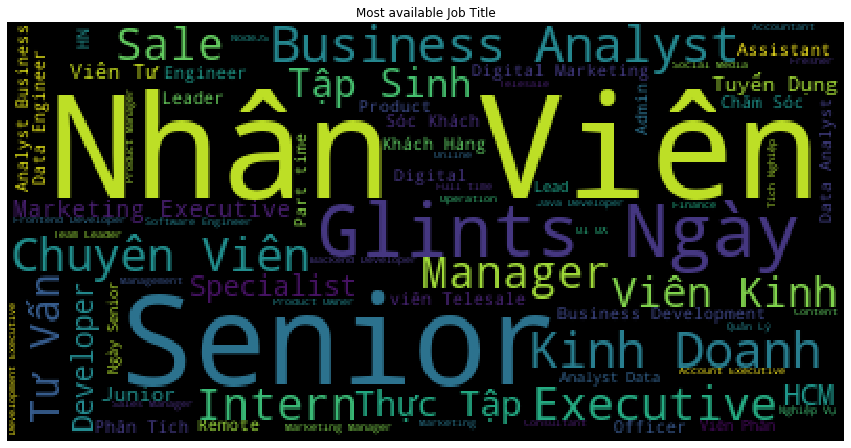

In [239]:
df_data = df[df.job_title.str.contains('Data')]

plt.subplots(figsize=(15,15))
wc = WordCloud()
text = df['job_title']
wc.generate(str(' '.join(text)))
plt.imshow(wc)
plt.axis("off")
plt.title("Most available Job Title")
plt.show()

In [84]:
text_requirement = ','.join(x for x in df.requirement)
text_requirement

df_data = df[df.job_title.str.contains('Data')]
text_requirement_data = ','.join(x for x in df_data.requirement)

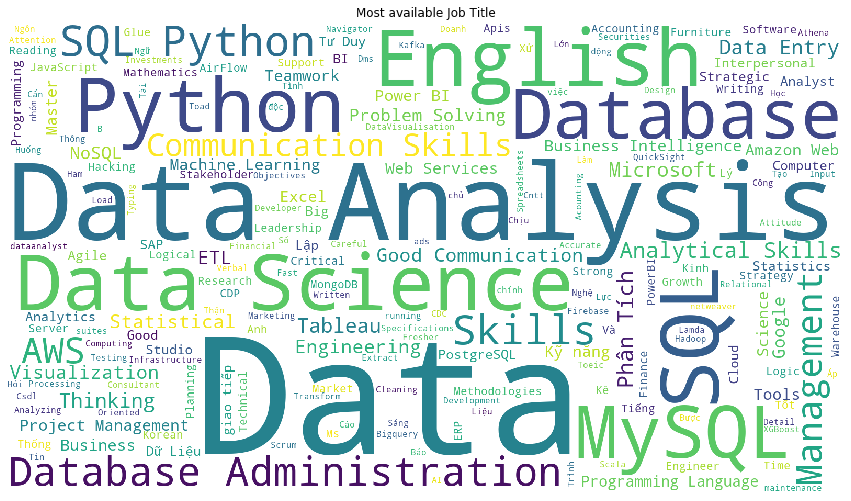

In [266]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

plt.subplots(figsize=(15,15))
wc = WordCloud(width = 1600, height = 900,
                background_color ='white',
                min_font_size = 10,
              random_state = 1)
wc.generate(text_requirement_data)
plt.imshow(wc)
plt.axis("off")
plt.title("Most available Job Title")
plt.show()

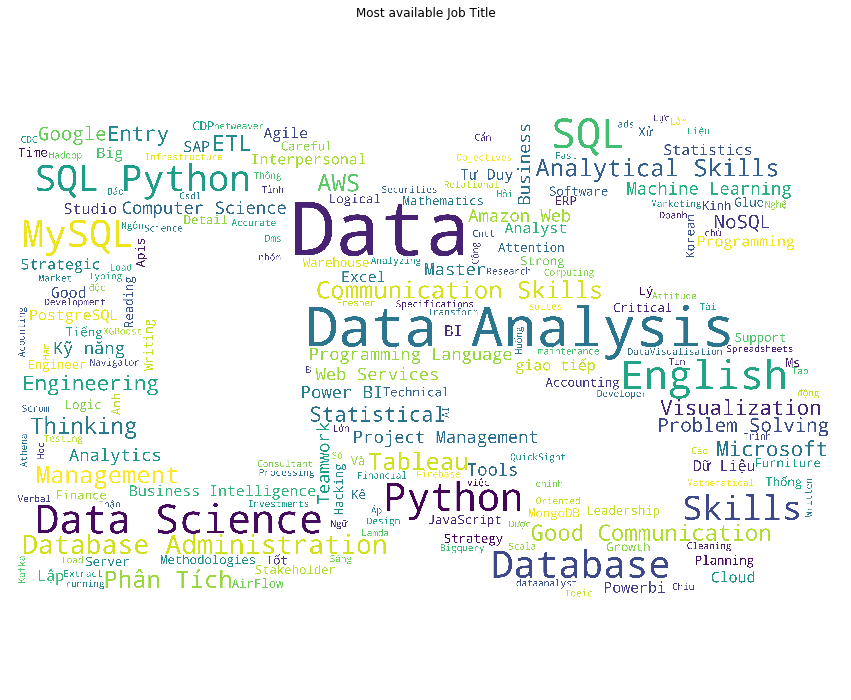

In [91]:
#Ref: https://towardsdatascience.com/create-word-cloud-into-any-shape-you-want-using-python-d0b88834bc32

# from PIL import Image
# from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator
# import matplotlib.pyplot as plt
# import numpy as np
plt.subplots(figsize=(15,15))
mask_ = np.array(Image.open('DS.png'))
#inverse mask
mask_inverse = np.where(mask_==0, 255, mask_)
wc2 = WordCloud(width = 1600, height = 900,
                background_color ='white',
                mask = mask_inverse,
               random_state = 1)
# Generate a wordcloud
wc2.generate(text_requirement_data)
plt.imshow(wc2)
plt.axis("off")
plt.title("Most available Job Title")

plt.savefig('worldcloud.png', dpi = 200, format ='png', transparent = True)
plt.show()


In [87]:
plt.savefig('wordcloud.png')

<Figure size 432x288 with 0 Axes>